# Analysis of Helsinki city bike usage in different districts in 2019

For plotting please install `mapclassify` for the quantiles scheme in matplotlib and `bokeh` for interactive maps.

In [309]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from bokeh.io import output_file, output_notebook, show
from bokeh.plotting import figure, save
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, LogColorMapper
import bokeh.palettes
output_notebook()

Loading BokehJS ...

In [107]:
rides_total = pd.read_csv("rides_between_districts.csv")
rides_total = rides_total.drop(columns=["Unnamed: 0"])
rides_total = rides_total.astype({"start_district": str, "finish_district": str, "count": int}).replace({"start_district": "0", "finish_district": "0"},"000")

rides_day = pd.read_csv("rides_between_districts_by_dow.csv")
rides_day = rides_day.drop(columns=["Unnamed: 0"])
rides_day = rides_day.astype({"start_district": str, "finish_district": str, "count": int}).replace({"start_district": "0", "finish_district": "0"},"000")


rides_time = pd.read_csv("rides_between_districts_by_time.csv")
rides_time = rides_time.drop(columns=["Unnamed: 0"])
rides_time = rides_time.astype({"start_district": str, "finish_district": str, "count": int}).replace({"start_district": "0", "finish_district": "0"},"000")

In [69]:
helsinki = gpd.read_file("data/Helsingin_peruspiirit.geojson")
helsinki = helsinki.drop(columns=["kokotunnus", "kunta"])
helsinki

,id,name,geometry
0,101,Vironniemi,"POLYGON ((25496230.663 6674007.871, 25496260.2..."
1,102,Ullanlinna,"POLYGON ((25487917.082 6665229.637, 25489108.9..."
2,103,Kampinmalmi,"POLYGON ((25493462.419 6673254.257, 25494179.7..."
3,104,Taka-Töölö,"POLYGON ((25494394.500 6674325.429, 25494444.4..."
4,105,Lauttasaari,"POLYGON ((25491014.878 6670145.496, 25491000.6..."
5,201,Reijola,"POLYGON ((25493156.569 6674793.588, 25492719.1..."
6,202,Munkkiniemi,"POLYGON ((25491279.946 6675893.666, 25491281.8..."
7,203,Haaga,"POLYGON ((25492611.223 6680219.218, 25492611.1..."
8,204,Pitäjänmäki,"POLYGON ((25490664.517 6682390.219, 25490679.6..."
9,205,Kaarela,"POLYGON ((25490791.048 6682458.057, 25490844.3..."


In [70]:
espoo = gpd.read_file("data/Espoo_alue.geojson")
espoo["id"] = "000"
espoo = espoo.rename(columns={"KAUPUNKI": "name"})
espoo["name"] = espoo["name"].str.title()
espoo = espoo[["id", "name", "geometry"]]
espoo

,id,name,geometry
0,000,Espoo,"POLYGON ((2765665.222 8436783.461, 2765666.558..."


In [71]:
espoo = espoo.to_crs(helsinki.crs)
districts = helsinki.append(espoo)
districts = districts.sort_values("id").reset_index(drop=True)
districts

,id,name,geometry
0,000,Espoo,"POLYGON ((25491360.686 6672574.884, 25491361.2..."
1,101,Vironniemi,"POLYGON ((25496230.663 6674007.871, 25496260.2..."
2,102,Ullanlinna,"POLYGON ((25487917.082 6665229.637, 25489108.9..."
3,103,Kampinmalmi,"POLYGON ((25493462.419 6673254.257, 25494179.7..."
4,104,Taka-Töölö,"POLYGON ((25494394.500 6674325.429, 25494444.4..."
5,105,Lauttasaari,"POLYGON ((25491014.878 6670145.496, 25491000.6..."
6,201,Reijola,"POLYGON ((25493156.569 6674793.588, 25492719.1..."
7,202,Munkkiniemi,"POLYGON ((25491279.946 6675893.666, 25491281.8..."
8,203,Haaga,"POLYGON ((25492611.223 6680219.218, 25492611.1..."
9,204,Pitäjänmäki,"POLYGON ((25490664.517 6682390.219, 25490679.6..."


<AxesSubplot:>

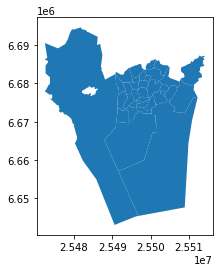

In [72]:
districts.plot()

## Outgoing ride statistics for every district

In [152]:
rides_total

,start_district,finish_district,count,total_distance,total_duration
0,000,101,414,3711751.0,997766.0
1,000,102,303,2782139.0,757030.0
2,000,103,3508,24661429.0,6767523.0
3,000,104,1359,9417150.0,2438733.0
4,000,105,7470,35474228.0,9792834.0
...,...,...,...,...,...
548,702,601,122,771628.0,196046.0
549,702,602,1039,3545073.0,895377.0
550,702,603,15,107297.0,27821.0
551,702,701,2957,5331717.0,1336593.0


In [196]:
df_out = rides_total[rides_total["start_district"] != rides_total["finish_district"]]
df_out = df_out.rename(columns={"start_district": "id"})
df_out = df_out.groupby("id").sum()
df_out = pd.merge(districts, df_out, on="id")
df_out

,id,name,geometry,count,total_distance,total_duration
0,000,Espoo,"POLYGON ((25491360.686 6672574.884, 25491361.2...",37279,185098916.0,48952915.0
1,101,Vironniemi,"POLYGON ((25496230.663 6674007.871, 25496260.2...",337922,730013035.0,211669081.0
2,102,Ullanlinna,"POLYGON ((25487917.082 6665229.637, 25489108.9...",193674,427688900.0,121260043.0
3,103,Kampinmalmi,"POLYGON ((25493462.419 6673254.257, 25494179.7...",371533,868463167.0,249072501.0
4,104,Taka-Töölö,"POLYGON ((25494394.500 6674325.429, 25494444.4...",168213,402354231.0,113108179.0
5,105,Lauttasaari,"POLYGON ((25491014.878 6670145.496, 25491000.6...",61651,223493787.0,61181856.0
6,201,Reijola,"POLYGON ((25493156.569 6674793.588, 25492719.1...",120493,369797428.0,100825498.0
7,202,Munkkiniemi,"POLYGON ((25491279.946 6675893.666, 25491281.8...",56147,181339095.0,50173932.0
8,203,Haaga,"POLYGON ((25492611.223 6680219.218, 25492611.1...",36472,124042397.0,33871317.0
9,204,Pitäjänmäki,"POLYGON ((25490664.517 6682390.219, 25490679.6...",21991,73207639.0,19593730.0


Let us plot this using quantiles. Basically, uneven intervals for the values we plot decided by the program. 

Text(0.5, 1.0, 'Outgoing total ride distance per district')

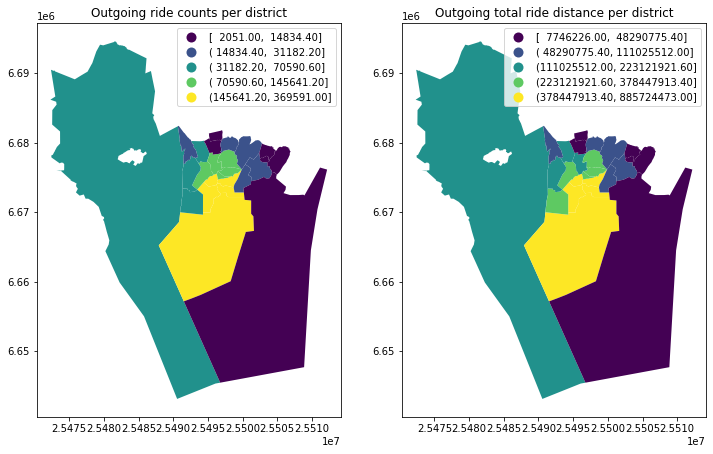

In [209]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
df.plot(ax=ax1, column='count', legend=True, scheme='quantiles')
ax1.set_title("Outgoing ride counts per district")
df.plot(ax=ax2, column='total_distance', legend=True, scheme='quantiles')
ax2.set_title("Outgoing total ride distance per district")

To get a better idea of the distribution, we can also plot this using equal intervals.

Text(0.5, 1.0, 'Outgoing total ride distance per district')

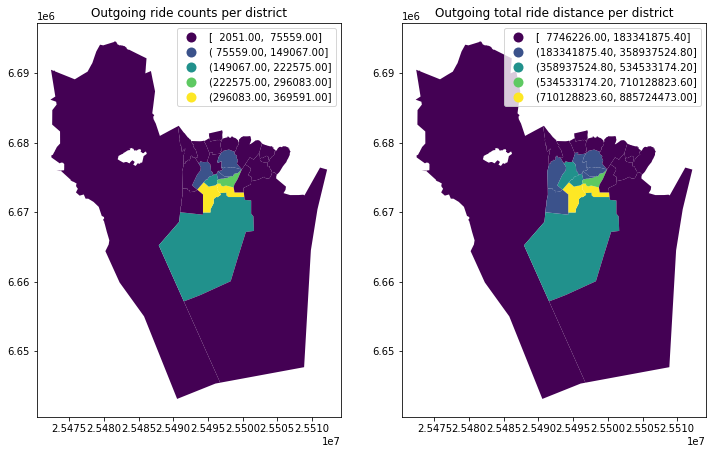

In [210]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
df.plot(ax=ax1, column='count', legend=True, scheme='equal_interval')
ax1.set_title("Outgoing ride counts per district")
df.plot(ax=ax2, column='total_distance', legend=True, scheme='equal_interval')
ax2.set_title("Outgoing total ride distance per district")

In [211]:
df_out.describe()

,count,total_distance,total_duration
count,24.000000,2.400000e+01,2.400000e+01
mean,90098.916667,2.344995e+08,6.572907e+07
std,103285.968982,2.307408e+08,6.631052e+07
min,1748.000000,6.808547e+06,1.856680e+06
25%,16113.500000,5.433941e+07,1.478822e+07
50%,46713.000000,1.832190e+08,4.956342e+07
75%,125774.500000,3.469779e+08,9.535205e+07
max,371533.000000,8.684632e+08,2.490725e+08


In [212]:
df_out.sort_values("count", ascending=False)

,id,name,geometry,count,total_distance,total_duration
3,103,Kampinmalmi,"POLYGON ((25493462.419 6673254.257, 25494179.7...",371533,868463167.0,249072501.0
1,101,Vironniemi,"POLYGON ((25496230.663 6674007.871, 25496260.2...",337922,730013035.0,211669081.0
10,301,Kallio,"POLYGON ((25496307.284 6674481.839, 25496393.6...",219254,550443624.0,156969183.0
2,102,Ullanlinna,"POLYGON ((25487917.082 6665229.637, 25489108.9...",193674,427688900.0,121260043.0
4,104,Taka-Töölö,"POLYGON ((25494394.500 6674325.429, 25494444.4...",168213,402354231.0,113108179.0
12,303,Vallila,"POLYGON ((25496458.274 6675967.792, 25496476.0...",141619,339371410.0,93527571.0
6,201,Reijola,"POLYGON ((25493156.569 6674793.588, 25492719.1...",120493,369797428.0,100825498.0
11,302,Alppiharju,"POLYGON ((25496262.580 6675559.880, 25496263.5...",109825,249473297.0,68180681.0
14,305,Vanhakaupunki,"POLYGON ((25496325.202 6677158.787, 25496329.3...",89002,281928281.0,78636357.0
13,304,Pasila,"POLYGON ((25494873.235 6677319.815, 25494930.0...",85778,228606065.0,63224953.0


## Incoming ride statistics for every district

In [213]:
df_in = rides_total[rides_total["start_district"] != rides_total["finish_district"]]
df_in = df_in.rename(columns={"finish_district": "id"})
df_in = df_in.groupby("id").sum()
df_in = pd.merge(districts, df_in, on="id")

Text(0.5, 1.0, 'Incoming total ride distance per district')

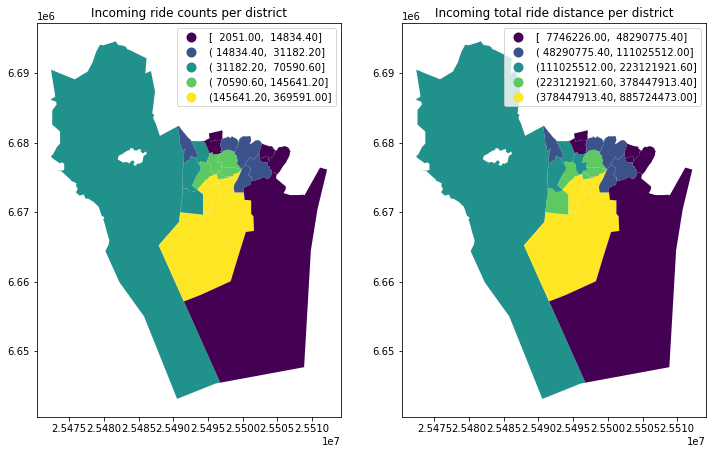

In [214]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
df_in.plot(ax=ax1, column='count', legend=True, scheme='quantiles')
ax1.set_title("Incoming ride counts per district")
df_in.plot(ax=ax2, column='total_distance', legend=True, scheme='quantiles')
ax2.set_title("Incoming total ride distance per district")

Text(0.5, 1.0, 'Incoming total ride distance per district')

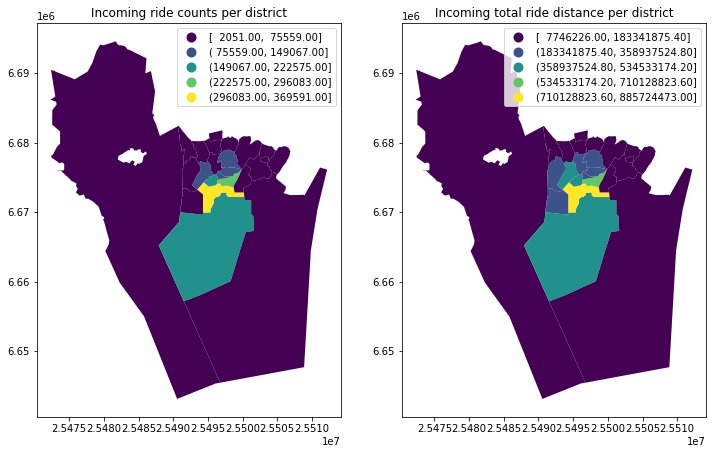

In [217]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
df_in.plot(ax=ax1, column='count', legend=True, scheme='equal_interval')
ax1.set_title("Incoming ride counts per district")
df_in.plot(ax=ax2, column='total_distance', legend=True, scheme='equal_interval')
ax2.set_title("Incoming total ride distance per district")

In [216]:
df_in.describe()

,count,total_distance,total_duration
count,24.000000,2.400000e+01,2.400000e+01
mean,90098.916667,2.344995e+08,6.572907e+07
std,104180.812431,2.341691e+08,6.559930e+07
min,2051.000000,7.746226e+06,2.203034e+06
25%,16478.250000,5.479710e+07,1.536570e+07
50%,48703.500000,1.845061e+08,4.948706e+07
75%,121007.500000,3.229749e+08,9.384242e+07
max,369591.000000,8.857245e+08,2.521540e+08


In [205]:
df_in.sort_values("count", ascending=False)

,id,name,geometry,count,total_distance,total_duration
3,103,Kampinmalmi,"POLYGON ((25493462.419 6673254.257, 25494179.7...",369591,885724473.0,252154002.0
1,101,Vironniemi,"POLYGON ((25496230.663 6674007.871, 25496260.2...",345100,744235431.0,203406665.0
10,301,Kallio,"POLYGON ((25496307.284 6674481.839, 25496393.6...",223683,557837991.0,153514832.0
2,102,Ullanlinna,"POLYGON ((25487917.082 6665229.637, 25489108.9...",205128,444518858.0,126583167.0
4,104,Taka-Töölö,"POLYGON ((25494394.500 6674325.429, 25494444.4...",168941,398370461.0,110487195.0
12,303,Vallila,"POLYGON ((25496458.274 6675967.792, 25496476.0...",130108,308911137.0,91644258.0
6,201,Reijola,"POLYGON ((25493156.569 6674793.588, 25492719.1...",117974,365166215.0,100436895.0
11,302,Alppiharju,"POLYGON ((25496262.580 6675559.880, 25496263.5...",101905,233016619.0,71028917.0
14,305,Vanhakaupunki,"POLYGON ((25496325.202 6677158.787, 25496329.3...",93584,289950711.0,80436782.0
13,304,Pasila,"POLYGON ((25494873.235 6677319.815, 25494930.0...",72669,190749097.0,58346659.0


## Net rides for each district
Here we investigate the difference between incoming and outgoing rides. A significant difference indicates that city bikes are used in only one direction (in or out).

Reasons could include 
- an easier one-way route
- exchange of city bikes to reset the timer (meaning that the origin of the route is not in that district)
- habits of people (e.g. taking the bike to work, but the train from work)

In [206]:
df_net = df_in
df_net["count"] = df_net["count"] - df_out["count"]
df_net["total_distance"] = df_net["total_distance"] - df_out["total_distance"]
df_net["total_duration"] = df_net["total_duration"] - df_out["total_duration"]
df_net

,id,name,geometry,count,total_distance,total_duration
0,000,Espoo,"POLYGON ((25491360.686 6672574.884, 25491361.2...",-1060,-6835912.0,-2014730.0
1,101,Vironniemi,"POLYGON ((25496230.663 6674007.871, 25496260.2...",7178,14222396.0,-8262416.0
2,102,Ullanlinna,"POLYGON ((25487917.082 6665229.637, 25489108.9...",11454,16829958.0,5323124.0
3,103,Kampinmalmi,"POLYGON ((25493462.419 6673254.257, 25494179.7...",-1942,17261306.0,3081501.0
4,104,Taka-Töölö,"POLYGON ((25494394.500 6674325.429, 25494444.4...",728,-3983770.0,-2620984.0
5,105,Lauttasaari,"POLYGON ((25491014.878 6670145.496, 25491000.6...",626,5879190.0,1533041.0
6,201,Reijola,"POLYGON ((25493156.569 6674793.588, 25492719.1...",-2519,-4631213.0,-388603.0
7,202,Munkkiniemi,"POLYGON ((25491279.946 6675893.666, 25491281.8...",4808,16778605.0,1862003.0
8,203,Haaga,"POLYGON ((25492611.223 6680219.218, 25492611.1...",-20,908807.0,645712.0
9,204,Pitäjänmäki,"POLYGON ((25490664.517 6682390.219, 25490679.6...",670,-769485.0,700091.0


Text(0.5, 1.0, 'Net total ride distance per district')

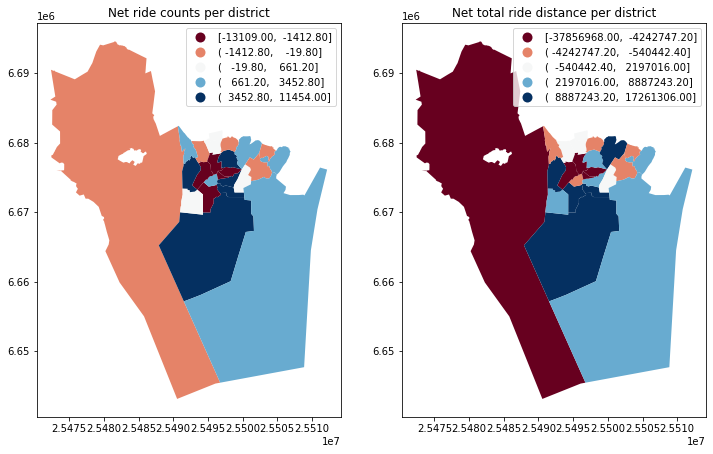

In [294]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
df_net.plot(ax=ax1, column='count', legend=True, scheme='quantiles', cmap='RdBu')
ax1.set_title("Net ride counts per district")
df_net.plot(ax=ax2, column='total_distance', legend=True, scheme='quantiles', cmap='RdBu')
ax2.set_title("Net total ride distance per district")

Here, the more red one district is, the more outgoing rides it has. A dark blue colour indicates that there is a lot of incoming rides for that district. A very light colour, close to white, would show that the incoming and outgoing rides are somewhat balanced.

Text(0.5, 1.0, 'Net total ride distance per district')

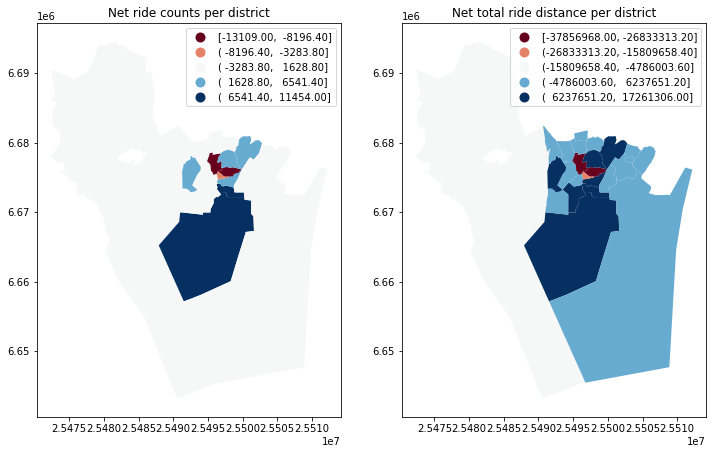

In [270]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
df_net.plot(ax=ax1, column='count', legend=True, scheme='equal_interval', cmap='RdBu')
ax1.set_title("Net ride counts per district")
df_net.plot(ax=ax2, column='total_distance', legend=True, scheme='equal_interval', cmap='RdBu')
ax2.set_title("Net total ride distance per district")

Due to the fact that it is difficult to get the district names on these plots, let's recreate them using bokeh, an interactive plotting tool.

In [295]:
def getPolyCoords(row, geom, coord_type):
    if coord_type == 'x':
        return list(row[geom].exterior.coords.xy[0])
    elif coord_type == 'y':
        return list(row[geom].exterior.coords.xy[1])

In [347]:
df_net['x'] = df_net.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_net['y'] = df_net.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_net.drop('geometry', axis = 1).copy()
p = figure(title = "Net ride count for each district")

color_mapper = LinearColorMapper(palette=bokeh.palettes.RdBu[10][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p.add_tools(ghover)
show(p)

## Example - Ride statistics for Ullanlinna (102)
First, we plot the count of rides starting in Ullanlinna for each destination district.

In [363]:
df_out = rides_total[rides_total["start_district"] == "102"]
df_out = df_out.rename(columns={"finish_district": "id"})
df_out = pd.merge(districts, df_out, on="id")
df_out

,id,name,geometry,x,y,start_district,count,total_distance,total_duration
0,000,Espoo,"POLYGON ((25491360.686 6672574.884, 25491361.2...","[25491360.68593429, 25491361.285090342, 254913...","[6672574.884372138, 6672546.405155652, 6672531...",102,328,2869191.0,782548.0
1,101,Vironniemi,"POLYGON ((25496230.663 6674007.871, 25496260.2...","[25496230.6629, 25496260.2666, 25496275.1446, ...","[6674007.8706, 6673907.6426, 6673911.9891, 667...",102,63505,96940488.0,27436319.0
2,102,Ullanlinna,"POLYGON ((25487917.082 6665229.637, 25489108.9...","[25487917.0821, 25489108.9166, 25491530.4254, ...","[6665229.637, 6662564.0141, 6657152.9018, 6657...",102,78129,87386377.0,25732933.0
3,103,Kampinmalmi,"POLYGON ((25493462.419 6673254.257, 25494179.7...","[25493462.4188, 25494179.7646, 25494293.5621, ...","[6673254.2571, 6672654.796, 6672560.5334, 6672...",102,79184,140245827.0,40957435.0
4,104,Taka-Töölö,"POLYGON ((25494394.500 6674325.429, 25494444.4...","[25494394.4998769, 25494444.4466648, 25494802....","[6674325.42935366, 6674281.64139587, 6673967.9...",102,8399,26810705.0,7345392.0
5,105,Lauttasaari,"POLYGON ((25491014.878 6670145.496, 25491000.6...","[25491014.8777, 25491000.638, 25492634.2109, 2...","[6670145.496, 6669998.2361, 6669822.8245, 6669...",102,6096,26100066.0,7098632.0
6,201,Reijola,"POLYGON ((25493156.569 6674793.588, 25492719.1...","[25493156.5692, 25492719.1748, 25493462.4188, ...","[6674793.5882, 6673875.3617, 6673254.2571, 667...",102,3107,14851767.0,4014994.0
7,202,Munkkiniemi,"POLYGON ((25491279.946 6675893.666, 25491281.8...","[25491279.9464, 25491281.8618, 25491309.9092, ...","[6675893.6655, 6675823.6935, 6674742.0762, 667...",102,795,5006891.0,1317438.0
8,203,Haaga,"POLYGON ((25492611.223 6680219.218, 25492611.1...","[25492611.2234, 25492611.1156, 25492611.9035, ...","[6680219.2176, 6680212.7178, 6680202.7171, 668...",102,163,1176027.0,311067.0
9,204,Pitäjänmäki,"POLYGON ((25490664.517 6682390.219, 25490679.6...","[25490664.5168, 25490679.6746, 25490683.9904, ...","[6682390.2187, 6682295.4188, 6682268.4632, 668...",102,34,301470.0,81208.0


In [364]:
df_out['x'] = df_out.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_out['y'] = df_out.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_out.drop('geometry', axis = 1).copy()
p = figure(title = "Ride count for rides starting in Ullanlinna for each district")

color_mapper = LogColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p.add_tools(ghover)
show(p)

Next, we can investigate all rides ending in Ullanlinna.

In [365]:
df_in = rides_total[rides_total["finish_district"] == "102"]
df_in = df_in.rename(columns={"start_district": "id"})
df_in = pd.merge(districts, df_in, on="id")
df_in

,id,name,geometry,x,y,finish_district,count,total_distance,total_duration
0,000,Espoo,"POLYGON ((25491360.686 6672574.884, 25491361.2...","[25491360.68593429, 25491361.285090342, 254913...","[6672574.884372138, 6672546.405155652, 6672531...",102,303,2782139.0,757030.0
1,101,Vironniemi,"POLYGON ((25496230.663 6674007.871, 25496260.2...","[25496230.6629, 25496260.2666, 25496275.1446, ...","[6674007.8706, 6673907.6426, 6673911.9891, 667...",102,63902,97283252.0,28943053.0
2,102,Ullanlinna,"POLYGON ((25487917.082 6665229.637, 25489108.9...","[25487917.0821, 25489108.9166, 25491530.4254, ...","[6665229.637, 6662564.0141, 6657152.9018, 6657...",102,78129,87386377.0,25732933.0
3,103,Kampinmalmi,"POLYGON ((25493462.419 6673254.257, 25494179.7...","[25493462.4188, 25494179.7646, 25494293.5621, ...","[6673254.2571, 6672654.796, 6672560.5334, 6672...",102,89546,156451944.0,45693569.0
4,104,Taka-Töölö,"POLYGON ((25494394.500 6674325.429, 25494444.4...","[25494394.4998769, 25494444.4466648, 25494802....","[6674325.42935366, 6674281.64139587, 6673967.9...",102,9099,29163820.0,7834393.0
5,105,Lauttasaari,"POLYGON ((25491014.878 6670145.496, 25491000.6...","[25491014.8777, 25491000.638, 25492634.2109, 2...","[6670145.496, 6669998.2361, 6669822.8245, 6669...",102,6427,27252142.0,7389207.0
6,201,Reijola,"POLYGON ((25493156.569 6674793.588, 25492719.1...","[25493156.5692, 25492719.1748, 25493462.4188, ...","[6674793.5882, 6673875.3617, 6673254.2571, 667...",102,3093,14606365.0,3821923.0
7,202,Munkkiniemi,"POLYGON ((25491279.946 6675893.666, 25491281.8...","[25491279.9464, 25491281.8618, 25491309.9092, ...","[6675893.6655, 6675823.6935, 6674742.0762, 667...",102,798,5035895.0,1350438.0
8,203,Haaga,"POLYGON ((25492611.223 6680219.218, 25492611.1...","[25492611.2234, 25492611.1156, 25492611.9035, ...","[6680219.2176, 6680212.7178, 6680202.7171, 668...",102,218,1607215.0,422086.0
9,204,Pitäjänmäki,"POLYGON ((25490664.517 6682390.219, 25490679.6...","[25490664.5168, 25490679.6746, 25490683.9904, ...","[6682390.2187, 6682295.4188, 6682268.4632, 668...",102,37,329246.0,86035.0


In [366]:
df_in['x'] = df_in.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_in['y'] = df_in.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_in.drop('geometry', axis = 1).copy()
p = figure(title = "Ride count for rides ending in Ullanlinna for each district")

color_mapper = LogColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p.add_tools(ghover)
show(p)

Lastly, we can look at the difference of rides starting and ending in Ullanlinna for each district.

In [367]:
df_net = df_in
df_net["count"] = df_net["count"] - df_out["count"]
df_net["total_distance"] = df_net["total_distance"] - df_out["total_distance"]
df_net["total_duration"] = df_net["total_duration"] - df_out["total_duration"]
df_net

,id,name,geometry,x,y,finish_district,count,total_distance,total_duration
0,000,Espoo,"POLYGON ((25491360.686 6672574.884, 25491361.2...","[25491360.68593429, 25491361.285090342, 254913...","[6672574.884372138, 6672546.405155652, 6672531...",102,-25.0,-87052.0,-25518.0
1,101,Vironniemi,"POLYGON ((25496230.663 6674007.871, 25496260.2...","[25496230.6629, 25496260.2666, 25496275.1446, ...","[6674007.8706, 6673907.6426, 6673911.9891, 667...",102,397.0,342764.0,1506734.0
2,102,Ullanlinna,"POLYGON ((25487917.082 6665229.637, 25489108.9...","[25487917.0821, 25489108.9166, 25491530.4254, ...","[6665229.637, 6662564.0141, 6657152.9018, 6657...",102,0.0,0.0,0.0
3,103,Kampinmalmi,"POLYGON ((25493462.419 6673254.257, 25494179.7...","[25493462.4188, 25494179.7646, 25494293.5621, ...","[6673254.2571, 6672654.796, 6672560.5334, 6672...",102,10362.0,16206117.0,4736134.0
4,104,Taka-Töölö,"POLYGON ((25494394.500 6674325.429, 25494444.4...","[25494394.4998769, 25494444.4466648, 25494802....","[6674325.42935366, 6674281.64139587, 6673967.9...",102,700.0,2353115.0,489001.0
5,105,Lauttasaari,"POLYGON ((25491014.878 6670145.496, 25491000.6...","[25491014.8777, 25491000.638, 25492634.2109, 2...","[6670145.496, 6669998.2361, 6669822.8245, 6669...",102,331.0,1152076.0,290575.0
6,201,Reijola,"POLYGON ((25493156.569 6674793.588, 25492719.1...","[25493156.5692, 25492719.1748, 25493462.4188, ...","[6674793.5882, 6673875.3617, 6673254.2571, 667...",102,-14.0,-245402.0,-193071.0
7,202,Munkkiniemi,"POLYGON ((25491279.946 6675893.666, 25491281.8...","[25491279.9464, 25491281.8618, 25491309.9092, ...","[6675893.6655, 6675823.6935, 6674742.0762, 667...",102,3.0,29004.0,33000.0
8,203,Haaga,"POLYGON ((25492611.223 6680219.218, 25492611.1...","[25492611.2234, 25492611.1156, 25492611.9035, ...","[6680219.2176, 6680212.7178, 6680202.7171, 668...",102,55.0,431188.0,111019.0
9,204,Pitäjänmäki,"POLYGON ((25490664.517 6682390.219, 25490679.6...","[25490664.5168, 25490679.6746, 25490683.9904, ...","[6682390.2187, 6682295.4188, 6682268.4632, 668...",102,3.0,27776.0,4827.0


In [416]:
df_net['x'] = df_net.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_net['y'] = df_net.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_net.drop('geometry', axis = 1).copy()
p = figure(title = "Net ride count for rides starting/ending in Ullanlinna")

bounds = [-2000, -500, -50, 0, 50, 500, 2000, 20000]
base_colors = bokeh.palettes.RdBu[7][::-1]

low = -600
high = 600
bound_colors = []
j = 0
for i in range(low, high, 50):
    if i >= bounds[j+1]:
        j += 1
    bound_colors.append(base_colors[j])
    
color_mapper = LinearColorMapper(palette=bound_colors, low=low, high=high, nan_color="white")
grid = p.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p.add_tools(ghover)
show(p)

A positive number indicates that the were more rides taken to Ullanlinna than from that particular district. In other words, the "directionality" of the rides would be inwards. This is the case for e.g. Kampinmalmi (very extremely in fact).

A negative number shows that there were more rides taken from Ullanlinna to that district, which means that its directionality is outwards. An example for this would be Kallio.

In [419]:
df_net.sort_values("count", ascending=False)[["name", "count"]]

,name,count
3,Kampinmalmi,10362.0
4,Taka-Töölö,700.0
12,Vallila,643.0
1,Vironniemi,397.0
5,Lauttasaari,331.0
11,Alppiharju,150.0
13,Pasila,76.0
8,Haaga,55.0
14,Vanhakaupunki,24.0
18,Latokartano,8.0


## Demographic data

In [476]:
dem = pd.read_csv("Demographic data.csv")
dem = dem.rename(columns={"Postal Code": "id", "Ravintolat ": "restaurants", "Työttömyysaste": "unemployment", "Asukkaat yht": "tot_population"})
dem = dem.drop(columns=["District"])
dem = dem.astype({"id": str})
dem = dem.append(pd.Series({"id": "000"}), ignore_index=True)
dem = dem.sort_values("id").reset_index(drop=True)
dem = pd.merge(dem, districts, on="id")
dem

,id,Asukkaita/km2,tot_population,0-6-vuotiaat %,7-15-vuotiaat %,16-18-vuotiaat %,19-24-vuotiaat %,25-39-vuotiaat %,40-64-vuotiaat %,Yli 65-vuotiaat %,...,Pallokentät,Kirkko,Päivittäistavarakaupat,restaurants,Kahvilat ja baarit,unemployment,name,geometry,x,y
0,000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Espoo,"POLYGON ((25491360.686 6672574.884, 25491361.2...","[25491360.68593429, 25491361.285090342, 254913...","[6672574.884372138, 6672546.405155652, 6672531..."
1,101,6224.509804,12698.0,5.91,6.98,2.17,6.898724,25.783588,32.48,19.78,...,9.0,6.0,47.0,188.0,35.0,5.283923,Vironniemi,"POLYGON ((25496230.663 6674007.871, 25496260.2...","[25496230.6629, 25496260.2666, 25496275.1446, ...","[6674007.8706, 6673907.6426, 6673911.9891, 667..."
2,102,4100.000000,24477.0,5.76,6.56,1.66,8.052457,30.935164,30.66,16.37,...,14.0,6.0,43.0,175.0,23.0,5.855425,Ullanlinna,"POLYGON ((25487917.082 6665229.637, 25489108.9...","[25487917.0821, 25489108.9166, 25491530.4254, ...","[6665229.637, 6662564.0141, 6657152.9018, 6657..."
3,103,9564.018692,40934.0,6.20,5.93,1.71,9.671667,34.142766,27.80,14.55,...,12.0,8.0,69.0,278.0,33.0,6.168737,Kampinmalmi,"POLYGON ((25493462.419 6673254.257, 25494179.7...","[25493462.4188, 25494179.7646, 25494293.5621, ...","[6673254.2571, 6672654.796, 6672560.5334, 6672..."
4,104,7973.333333,15548.0,5.28,4.98,1.45,9.223051,34.268073,26.72,18.07,...,7.0,1.0,17.0,55.0,15.0,5.913635,Taka-Töölö,"POLYGON ((25494394.500 6674325.429, 25494444.4...","[25494394.4998769, 25494444.4466648, 25494802....","[6674325.42935366, 6674281.64139587, 6673967.9..."
5,105,6334.895833,24326.0,7.89,7.71,1.72,5.282414,30.091260,28.70,18.61,...,9.0,1.0,15.0,30.0,7.0,5.055120,Lauttasaari,"POLYGON ((25491014.878 6670145.496, 25491000.6...","[25491014.8777, 25491000.638, 25492634.2109, 2...","[6670145.496, 6669998.2361, 6669822.8245, 6669..."
6,201,3894.432071,17486.0,6.38,8.04,2.24,8.738419,28.680087,29.34,16.57,...,10.0,4.0,15.0,24.0,13.0,7.591729,Reijola,"POLYGON ((25493156.569 6674793.588, 25492719.1...","[25493156.5692, 25492719.1748, 25493462.4188, ...","[6674793.5882, 6673875.3617, 6673254.2571, 667..."
7,202,3859.784946,17948.0,6.37,8.62,2.64,6.892133,23.116782,30.61,21.76,...,19.0,2.0,16.0,21.0,5.0,5.955575,Munkkiniemi,"POLYGON ((25491279.946 6675893.666, 25491281.8...","[25491279.9464, 25491281.8618, 25491309.9092, ...","[6675893.6655, 6675823.6935, 6674742.0762, 667..."
8,203,5218.233083,27761.0,6.18,5.84,1.75,9.045063,33.085984,25.62,18.48,...,21.0,1.0,16.0,23.0,7.0,8.193318,Haaga,"POLYGON ((25492611.223 6680219.218, 25492611.1...","[25492611.2234, 25492611.1156, 25492611.9035, ...","[6680219.2176, 6680212.7178, 6680202.7171, 668..."
9,204,2762.724551,18455.0,7.38,8.01,2.57,7.911135,26.897860,31.02,16.21,...,11.0,1.0,14.0,30.0,3.0,10.198070,Pitäjänmäki,"POLYGON ((25490664.517 6682390.219, 25490679.6...","[25490664.5168, 25490679.6746, 25490683.9904, ...","[6682390.2187, 6682295.4188, 6682268.4632, 668..."


In [477]:
dem.columns

Index(['id', 'Asukkaita/km2', 'tot_population', '0-6-vuotiaat %',
       '7-15-vuotiaat %', '16-18-vuotiaat %', '19-24-vuotiaat %',
       '25-39-vuotiaat %', '40-64-vuotiaat %', 'Yli 65-vuotiaat %',
       'Tulot/asukas', 'Asuntokuntien mediaanitulot', 'Asuntoja yhteensä',
       'Liikerakennukset', 'Julkiset rakennukset',
       'Teollisuus- ja varastorakennukset', 'Päiväkoteja', 'Lukio koulut',
       'Erikois- ja erityiskoulut', 'Kirjasto', 'Terveysasema', 'Leikkipuisto',
       'Uimahalli', 'Liikuntasalit ja -hallit', 'Pallokentät', 'Kirkko',
       'Päivittäistavarakaupat', 'restaurants', 'Kahvilat ja baarit',
       'unemployment', 'name', 'geometry', 'x', 'y'],
      dtype='object')

In [457]:
dem['x'] = dem.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
dem['y'] = dem.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = dem.drop('geometry', axis = 1).copy()
p = figure(title = "Unemployment by district")
    
color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'unemployment', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Unemployment", "@unemployment")]
p.add_tools(ghover)
show(p)

In [475]:
dem['x'] = dem.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
dem['y'] = dem.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = dem.drop('geometry', axis = 1).copy()
p = figure(title = "Restaurants by district")
    
color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'restaurants', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Restaurants", "@restaurants")]
p.add_tools(ghover)
show(p)

In [478]:
dem['x'] = dem.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
dem['y'] = dem.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = dem.drop('geometry', axis = 1).copy()
p = figure(title = "Total population by district")
    
color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'tot_population', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Total Population", "@tot_population")]
p.add_tools(ghover)
show(p)